In [1]:
import requests
import io
url='https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
with requests.Session() as session:
    r = session.get(url, stream=True)
    r.raise_for_status()
    with open('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'wb') as hd5:
        for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
            hd5.write(chunk)

In [2]:
url='https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
with requests.Session() as session:
    r = session.get(url, stream=True)
    r.raise_for_status()
    with open('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'wb') as hd5:
        for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
            hd5.write(chunk)

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

data_electron = h5py.File('/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5')
data_photon = h5py.File('/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5')

In [3]:
data_electron['/X'].shape

(249000, 32, 32, 2)

In [3]:
datasets = [data_electron, data_photon]
X = np.concatenate([data['/X'][:128000] for data in datasets])
y = np.concatenate([data['/y'][:128000] for data in datasets])

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=35)


In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)

(184320, 32, 32, 2)
(20480, 32, 32, 2)
(51200, 32, 32, 2)
(184320,)


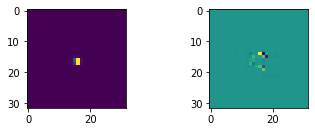

In [7]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[10,:,:,0])

plt.subplot(222)
plt.imshow(X_train[10,:,:,1])


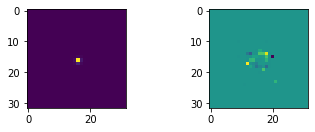

In [8]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[1000,:,:,0])


plt.subplot(222)
plt.imshow(X_train[1000,:,:,1])

In [10]:
tf.random.set_seed(42)

model = Sequential([
  Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 2)),
  Conv2D(32, (3,3), activation='relu'),
  Conv2D(64, (3,3), activation='relu'),
  Conv2D(64, (3,3), activation='relu'),
  MaxPool2D((2,2)),
  Flatten(),
  Dense(100, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history = model.fit(X_train, y_train, batch_size=32,
                        epochs=15,
                        validation_data=(X_val, y_val)
                        )
     

Epoch 1/15
5760/5760 [==============================] - 42s 7ms/step - loss: 0.6271 - accuracy: 0.6504 - val_loss: 0.5926 - val_accuracy: 0.6889
Epoch 2/15
5760/5760 [==============================] - 37s 6ms/step - loss: 0.5791 - accuracy: 0.7025 - val_loss: 0.5677 - val_accuracy: 0.7139
Epoch 3/15
5760/5760 [==============================] - 36s 6ms/step - loss: 0.5673 - accuracy: 0.7134 - val_loss: 0.5653 - val_accuracy: 0.7161
Epoch 4/15
5760/5760 [==============================] - 35s 6ms/step - loss: 0.5608 - accuracy: 0.7170 - val_loss: 0.5668 - val_accuracy: 0.7104
Epoch 5/15
5760/5760 [==============================] - 37s 6ms/step - loss: 0.5559 - accuracy: 0.7211 - val_loss: 0.5481 - val_accuracy: 0.7286
Epoch 6/15
5760/5760 [==============================] - 35s 6ms/step - loss: 0.5524 - accuracy: 0.7251 - val_loss: 0.5529 - val_accuracy: 0.7228
Epoch 7/15
5760/5760 [==============================] - 36s 6ms/step - loss: 0.5485 - accuracy: 0.7279 - val_loss: 0.5518 - val_ac

In [11]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

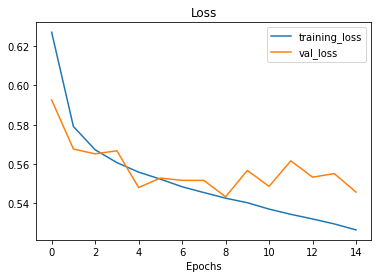

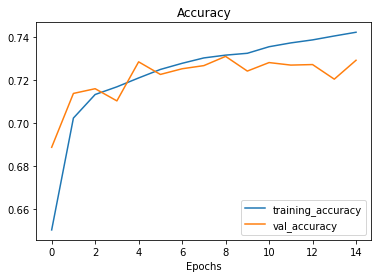

In [12]:
plot_loss_curves(history)

In [13]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1600/1600 [==============================] - 6s 3ms/step - loss: 0.5538 - accuracy: 0.7263
Loss = 0.5537940859794617
Test Accuracy = 0.7263085842132568


In [14]:
y_pred = model.predict(X_test)
y_proba = np.argmax(X_test,axis=1)

1600/1600 [==============================] - 4s 2ms/step


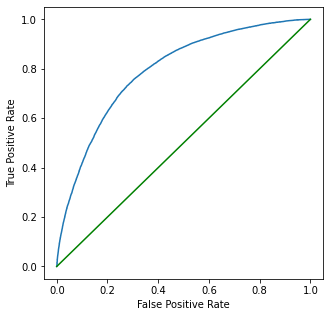

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
# Plots the ROC curve using the sklearn methods - Bad plot
plot_sklearn_roc_curve(y_test, y_pred)

In [16]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.7934
